# Single-loop vs. double-loop MC

The differences between single- and double-loop MC is explored for the performance recovery analysis problem.

In [213]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

## Constrained control parameter optimisation problem

Define a constrained optimisation problem where the control parameter is the only optimisation parameter; this mimics the perfomance recovery problem. The objective function, which is irrelevant here, is a function of the control parameter only. Two linear constraints are applied; the first is a function of control, design and uncertain parameters, and the second is just a function of the control parameter. Together, these define whether a feasible solution is possible or not.

In [214]:
def obj_fun(control):
    return control**2


def optimise_control_param(control_0, design, constraint_bounds, bounds):
    # Linear constraint defined as A*x >= b
    # Variable constraint is: control + design - uncertain >= 0
    # (1*control >= uncertain - design)
    # i.e. a requirement consisting of a design parameter, affected by some
    # uncertainty, with a control parameter to try to mitigate it
    # Defines problem: can the control parameter satisfy the constraint?
    A = np.array([1.0, 1.0])
    constraints = [
        optimize.LinearConstraint(
            A=A[0], lb=constraint_bounds[0, 0], ub=constraint_bounds[0, 1]
        ),
        optimize.LinearConstraint(
            A=A[1], lb=constraint_bounds[1, 0], ub=constraint_bounds[1, 1]
        ),
    ]
    result = optimize.minimize(
        fun=obj_fun,
        x0=control_0,
        method="SLSQP",
        constraints=constraints,
        bounds=optimize.Bounds(lb=bounds[0], ub=bounds[1]),
    )
    return result


# Perform optimisation of control parameter
control_0 = 2.0
design = 1.0
uncertain = 2.0
# Key aspect: lower limit of constraint depends on uncertain and design
constraint_bounds = np.array([[uncertain - design, np.inf], [-np.inf, 3.0]])
bounds = [0, 4]
result = optimise_control_param(
    control_0=control_0,
    design=design,
    constraint_bounds=constraint_bounds,
    bounds=bounds,
)
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.9999999999999867
       x: [ 1.000e+00]
     nit: 2
     jac: [ 2.000e+00]
    nfev: 4
    njev: 2

Plot example solution.

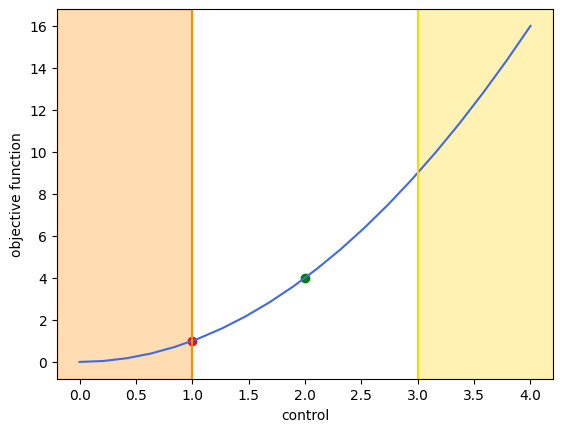

In [215]:
def plot(control_0, result, design, constraint_bounds, bounds):
    fig, ax = plt.subplots()
    x = np.linspace(bounds[0], bounds[1], 20)
    y = obj_fun(control=x)
    ax.plot(x, y, c="royalblue")
    ax.set_xlabel("control")
    ax.set_ylabel("objective function")
    ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]))
    ax.set_xlim((ax.get_xlim()[0], ax.get_xlim()[1]))

    # Constraint lines
    # Lower limit
    ax.vlines(
        constraint_bounds[0, 0],
        ymin=ax.get_ylim()[0],
        ymax=ax.get_ylim()[1],
        colors="darkorange",
    )
    ax.fill_betweenx(
        y=(ax.get_ylim()[0], ax.get_ylim()[1]),
        x1=ax.get_xlim()[0],
        x2=constraint_bounds[0, 0],
        color="darkorange",
        alpha=0.3,
    )
    # Upper limit
    ax.vlines(
        constraint_bounds[1, 1],
        ymin=ax.get_ylim()[0],
        ymax=ax.get_ylim()[1],
        colors="gold",
    )
    ax.fill_betweenx(
        y=(ax.get_ylim()[0], ax.get_ylim()[1]),
        x1=constraint_bounds[1, 1],
        x2=ax.get_xlim()[1],
        color="gold",
        alpha=0.3,
    )

    ax.scatter(control_0, obj_fun(control=control_0), c="g")
    ax.scatter(result.x, result.fun, c="r")


plot(
    control_0=control_0,
    result=result,
    design=design,
    constraint_bounds=constraint_bounds,
    bounds=bounds,
)

- Blue line: objective function (function of control)
- Orange region: violated region defined by uncertain and design parameters
- Yellow region: violated region defined by constant parameter
- Green point: initial optimisation parameter vector (control_0)
- Red point: final optimised point (control)

With constant design and uncertain parameters, a solution is found for the control variable, actively constrained by the orange linear constraint. This represents a single run of Graeme's optimisation problem: in this case, a solution has been found.

Now, Monte-Carlo the design and uncertain parameters, and see the effect on the ability to converge.

## MC design and uncertain parameters

In [216]:
# Separate seeded RNGs for comparison with double-loop later
rng1 = np.random.default_rng(seed=78)
rng2 = np.random.default_rng(seed=344)


def single_loop(n_samples):
    samples = []
    for i in range(n_samples):
        design = rng1.uniform(low=0.0, high=1.0)
        uncertain = rng2.uniform(low=3.0, high=5.0)
        constraint_bounds = np.array([[uncertain - design, np.inf], [-np.inf, 3.0]])

        result = optimise_control_param(
            control_0=control_0,
            design=design,
            constraint_bounds=constraint_bounds,
            bounds=bounds,
        )
        # Create extended dict for plotting individual sample
        sample = {
            "result": result,
            "design": design,
            "uncertain": uncertain,
            "constraint_bounds": constraint_bounds,
            "converged": result.success,
        }
        samples.append(sample)
    return samples


samples = single_loop(n_samples=10)

Examples of converged and non-converged cases.

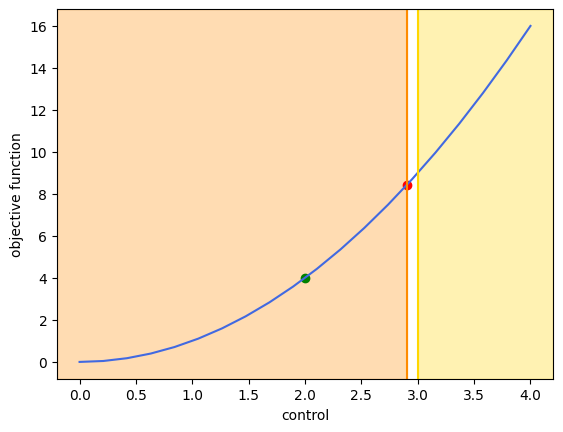

In [217]:
# Plot converged example
for sample in samples:
    if sample["converged"]:
        plot(
            control_0=control_0,
            result=sample["result"],
            design=sample["design"],
            constraint_bounds=sample["constraint_bounds"],
            bounds=bounds,
        )
        break

The control parameter is varied to find a feasible solution.

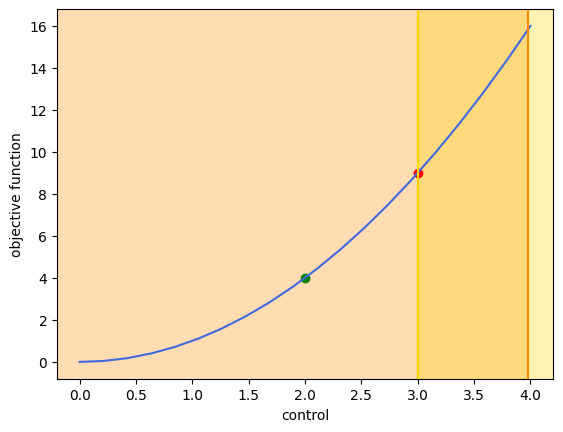

In [218]:
# Plot non-converged example
for sample in samples:
    if not sample["converged"]:
        plot(
            control_0=control_0,
            result=sample["result"],
            design=sample["design"],
            constraint_bounds=sample["constraint_bounds"],
            bounds=bounds,
        )
        break

No solution exists.

Now plot results in (design, uncertain) space.

In [219]:
# Create reduced dict (i.e. no objects) for plotting multiple samples in df
def samples_to_df(samples):
    sample_dict = {"design": [], "uncertain": [], "converged": []}
    for sample in samples:
        sample_dict["design"].append(sample["design"])
        sample_dict["uncertain"].append(sample["uncertain"])
        sample_dict["converged"].append(sample["converged"])
    return pd.DataFrame(data=sample_dict)


sample_df = samples_to_df(samples=samples)
sample_df

,design,uncertain,converged
0,0.418863,4.397645,False
1,0.915135,3.820408,True
2,0.518117,4.949300,False
3,0.837128,3.727153,True
4,0.372335,4.856626,False
5,0.569593,4.964161,False
6,0.379736,3.864588,False
7,0.324141,3.420657,False
8,0.580871,4.611282,False
9,0.673198,4.844336,False


Text(0.5, 1.0, 'Single-loop MC of design and uncertain parameters, 10 samples.')

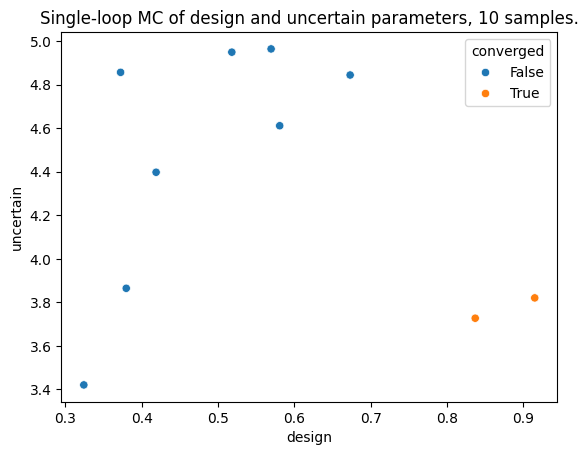

In [220]:
ax = sns.scatterplot(data=sample_df, x="design", y="uncertain", hue="converged")
ax.set_title("Single-loop MC of design and uncertain parameters, 10 samples.")

There is a single uncertain sample for each design, providing a binary value for convergence.

This indicates that solutions (performance recovery) are only possible for design >= 0.85.

## Double-loop MC

In [221]:
# Use separate seeded RNGs to keep design samples the same as in single-loop case
rng1 = np.random.default_rng(seed=78)
rng2 = np.random.default_rng(seed=344)

n_design_samples = 10
n_uncertain_samples = 10

samples = []
for i in range(n_design_samples):
    design = rng1.uniform(low=0.0, high=1.0)
    for j in range(n_uncertain_samples):
        uncertain = rng2.uniform(low=3.0, high=5.0)
        constraint_bounds = np.array([[uncertain - design, np.inf], [-np.inf, 3.0]])

        result = optimise_control_param(
            control_0=control_0,
            design=design,
            constraint_bounds=constraint_bounds,
            bounds=bounds,
        )
        # Create extended dict for plotting individual sample
        sample = {
            "result": result,
            "design": design,
            "uncertain": uncertain,
            "constraint_bounds": constraint_bounds,
            "converged": result.success,
        }
        samples.append(sample)

Text(0.5, 1.0, 'Double-loop MC of design and uncertain parameters, 100 samples.')

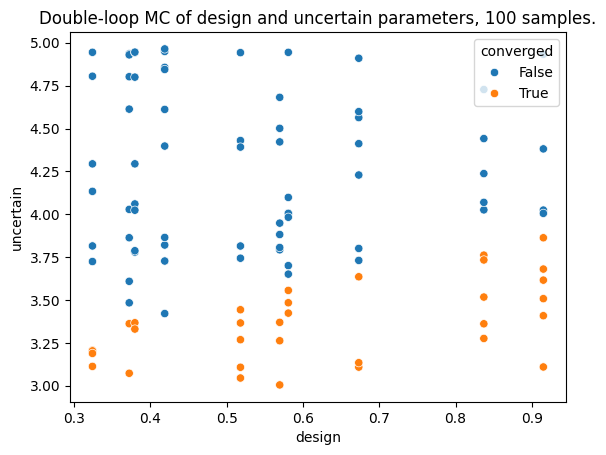

In [222]:
sample_df = samples_to_df(samples=samples)
ax = sns.scatterplot(data=sample_df, x="design", y="uncertain", hue="converged")
ax.set_title("Double-loop MC of design and uncertain parameters, 100 samples.")

There are now multiple uncertain samples for each design, providing a statistic about convergence.

This shows that solutions (performance recovery) are possible for all values of design, not just >= 0.85, as long as the uncertain values are within a certain range.

However, this isn't a fair comparison, as in the single-loop case we took 10 samples, whereas in the double-loop case we took 100. What about the single-loop case with 100 samples?

## Single-loop MC with same sample number as double-loop

Text(0.5, 1.0, 'Single-loop MC of design and uncertain parameters, 100 samples.')

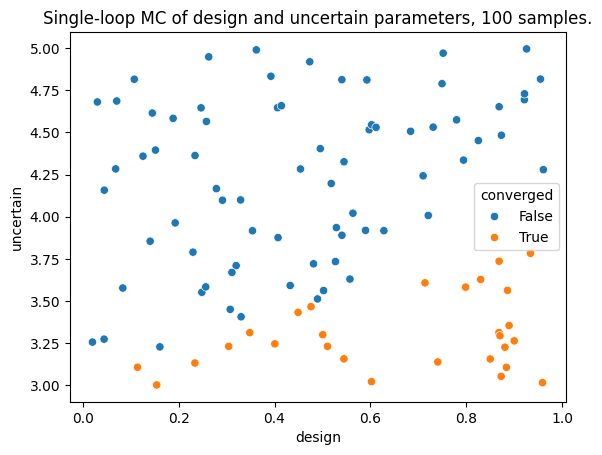

In [223]:
samples = single_loop(n_samples=100)
sample_df = samples_to_df(samples=samples)
ax = sns.scatterplot(data=sample_df, x="design", y="uncertain", hue="converged")
ax.set_title("Single-loop MC of design and uncertain parameters, 100 samples.")

A similar pattern to the double-loop case is now observed. However, no convergence statistics are possible without averaging over a range in the design space.

## Comments
### What I think is fact
- For the same number of samples, regions of convergence in the (design, uncertain) parameter space in the single-loop case are similar to the double-loop case
- In the double-loop case, a fixed design has its uncertain space fully explored, hence a convergence statistic is available for an exact design (e.g. 50% convergence under uncertainty)
- In the single-loop case, a fixed design only has a single uncertain sample, therefore it's necessary to average over a range of designs to gain exploration of the uncertain sample space (e.g. over a range of design in the above plot)
- The same uncertain sample will have a different effect on convergence for different designs (convergence is the result of an interaction effect between design and uncertain parameters). This is shown by the positive gradient in the true-false convergence boundary above

### Conjecture
I believe this interaction effect is ignored/assumed not to matter when averaging over a range of designs (a single design sample still only has a single uncertain sample); a lower-bound uncertain sample at the lower-bound of the design averaging range is assumed to have the same effect as at the upper-bound of the design averaging range

The motivation for the single-loop MC method is to reduce the number of samples by sampling both design and uncertain parameters at the same time, to make the problem computationally tractable. However, the price paid, I believe, is this ability to totally distinguish between the effect of design and uncertain parameters on response (convergence): a single design has a full uncertain exploration and corresponding convergence statistic. The double-loop method allows this, for a much higher computational cost.

With the single-loop MC method, to confidently make assertions about causal relationships between design and convergence, the design region being averaged over has to be sufficiently small, and the number of uncertain samples sufficiently large (i.e. tending towards the double-loop method). At what point that becomes "good enough" is difficult to say, as it requires a quantification of the variability in convergence due to the interactions between the varying range of design parameters being averaged over and the uncertain parameters; this would quantify the "confounding" effect of the differing designs in the averaging range on the convergence.

It's probably far easier to fix the design and sample the uncertain space thoroughly for a few design points to validate the accuracy of the single-loop method for the current number of samples. This is what I tried to do to in my reliability analysis of Graeme's "good" point, but I didn't understand that there were control variables at play too, which invalidated my analysis. This is equivalent to performing a single outer-loop iteration of the double-loop method.

Another thing worth thinking about is the total number of samples; in the design of experiments (which is what we're talking about here), it's possible to have "spurious correlations" due to undersampling (this leads to the inaccurate conclusion in the 10-sample SL-MC case). The general rule of thumb is an absolute bare minimum of $2^n$, where $n$ is the number of dimensions (above we have 100 samples for the 2D case, rather than 4). This would be $2^{n_{design}+{n_{uncertain}}}$ for the entire parameter space in this case, as the control parameters aren't being sampled.

However, when averaging over a range of design parameters to get a convergence rate for a given "region", I'm less certain how this works. For example, if there are 8 design parameters and 8 uncertain parameters and we wish to investigate the effect of design parameter 1 (design[1]) on convergence, then that would require a range of design[1] large enough to enclose at least $2^8 = 256$ uncertain samples (but small enough that design[1] wasn't varying too much simultaneously). However, the other 7 design parameters would be "confounders" in this case; they aren't going to be varying over a small range like design[1], as they're randomly sampled. How much would they "confound" the result?

I believe you'd require $2^7 = 128$ "other" design parameter samples in similarly small regions in each design parameter, $\times 2$ for the design[1] sampling range for a total of $2^{n_{design}+{n_{uncertain}}} = 65,536$ samples for each averaging region you want a convergence statistic for, assuming that you ignore the 7 design parameter confounders, or that their range is small enough, even when combined, to have negligible interaction effects with the uncertain parameters and hence not create a significant variance in the convergence.

### TLDR

I think:
- To separate the effects of design and uncertain parameters on convergence in single-loop sampling (and hence draw causal inferences about the effect of design parameters on convergence), enough samples are required (kinda obviously)
- Averaging over design parameter "regions" when they're undersampled will "smooth over" sparse samples and could produce spurious correlations
- It's important to consider the effect of "confounding" design parameters
- It's worth thinking about what is being lost by not doing double-loop MC (what is the cost of fewer samples?)